# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg, FacetNormal, CellDiameter
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler

Numba is set to use 8 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho = 1.0  # Density
mu = 1e-3  # Viscosity
U_mean = 1.0 # Mean inflow velocity
Re = rho * U_mean * D / mu
print(f"Reynolds number (Re): {Re:.2f}")

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 40, 40
# NX, NY = 40, 40
poly_order = 2
nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---
bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}


# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('ux', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('uy', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



=== DofHandler (CG) ===
        ux: 6561 DOFs @ offset 0
        uy: 6561 DOFs @ offset 9
         p: 1681 DOFs @ offset 18
  total : 14803
Number of interface edges: 92
Number of ghost edges: 50
Number of cut elements: 48


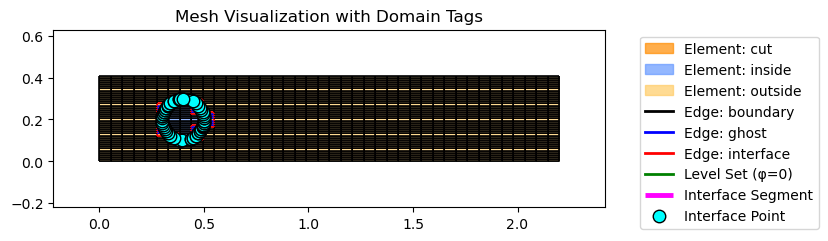

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [4]:
# --- Level Set for the Cylinder Obstacle ---
from matplotlib.pylab import f


level_set = CircleLevelSet(center=(c_x+0.2, c_y), radius=D ) # needs to correct the radius, also cx modified for debugging
mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = get_domain_bitset(mesh, "edge", "ghost")
physical_domain = fluid_domain | cut_domain

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
mixed_element = MixedElement(mesh, field_specs={'ux': 2, 'uy': 2, 'p': 1})
dof_handler = DofHandler(mixed_element, method='cg')
dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {ghost_edges.cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(10, 8))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=True, edge_colors=True)

In [5]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_space = FunctionSpace(name="velocity", field_names=['ux', 'uy'],dim=1)
pressure_space = FunctionSpace(name="pressure", field_names=['p'], dim=0)

# Trial and Test functions
du = VectorTrialFunction(space=velocity_space, dof_handler=dof_handler)
dp = TrialFunction(name='trial_pressure', field_name='p', dof_handler=dof_handler)
v = VectorTestFunction(space=velocity_space, dof_handler=dof_handler)
q = TestFunction(name='test_pressure', field_name='p', dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Parameters ---
dt = Constant(0.02)
theta = Constant(0.5) # Crank-Nicolson
mu_const = Constant(mu)
rho_const = Constant(rho)

u_k.nodal_values.fill(0.0); p_k.nodal_values.fill(0.0)
u_n.nodal_values.fill(0.0); p_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, u_n, p_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_n' as separate contour plots...


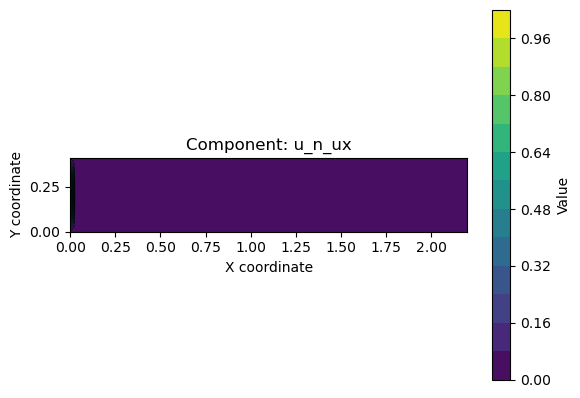

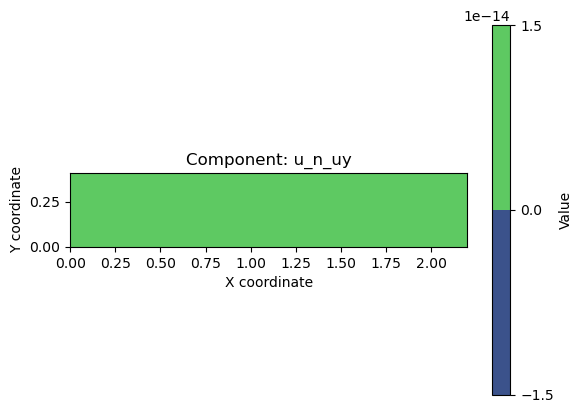

In [6]:
u_n.plot()

In [7]:
print(len(dof_handler.get_dirichlet_data(bcs)))

482


In [8]:
from pycutfem.ufl.expressions import Derivative
def grad_inner(u, v):
    if getattr(u, "num_components", 1) == 1:  # scalar case
        return _grad_comp(u, v)

    # vector case: sum component-wise
    if u.numcomponents == v.num_components == 2:
        return (
            Derivative(u[0], 1, 0) * Derivative(v[0], 1, 0)+
            Derivative(u[0], 0, 1) * Derivative(v[0], 0, 1) +
            Derivative(u[1], 1, 0) * Derivative(v[1], 1, 0) +
            Derivative(u[1], 0, 1) * Derivative(v[1], 0, 1)
        )
    else : raise ValueError("Unsupported number of components for gradient inner product.")


def _grad_comp(a, b):
    return (Derivative(a,1,0) * Derivative(b, 1,0) + Derivative(a, 0, 1) * Derivative(b, 0, 1))

dx_phys  = dx(defined_on=physical_domain,metadata={q:6})               # volume
dΓ        = dInterface(defined_on=mesh.element_bitset('cut'), level_set=level_set)   # interior surface
dG       = dGhost(defined_on=mesh.edge_bitset("ghost"), level_set=level_set)

n       = FacetNormal()                       # (nx , ny)
cell_h  = CellDiameter() # length‑scale per element
beta_N  = Constant(10.0 * poly_order**2)      # Nitsche penalty (tweak)

def epsilon(u):
    "Symmetric gradient."
    return 0.5 * (grad(u) + grad(u).T)

def sigma_dot_n(u_vec, p_scal):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return mu * (a + b) - p_scal * n         # vector of size 2

def sigma_dot_n_v(u_vec, p_scal,v_test):
    """
    Expanded form of (σ(u, p) · n) without using the '@' operator.

        σ(u, p)·n = μ (∇u + ∇uᵀ)·n  −  p n
    """
    # first term: μ (∇u)·n
    a = dot(grad(u_vec), n)
    # second term: μ (∇uᵀ)·n
    b = dot(grad(u_vec).T, n)
    # combine and subtract pressure part
    return mu * dot((a + b),v_test) - p_scal * dot(v_test,n)         # vector of size 2

# --- Jacobian contribution on Γsolid --------------------------------
J_int = (
    - sigma_dot_n_v(du, dp, v)           # consistency
    - sigma_dot_n_v(v, q, du)           # symmetry
    + beta_N * mu / cell_h * dot(du, v)     # penalty
) * dΓ

# --- Residual contribution on Γsolid --------------------------------
R_int = (
    - sigma_dot_n_v(u_k, p_k, v)
    - sigma_dot_n_v(v, q, u_k)
    + beta_N * mu / cell_h * dot(u_k, v)
) * dΓ

# volume ------------------------------------------------------------
a_vol = ( rho*dot(du,v)/dt
          + theta*rho*dot(dot(grad(u_k), du), v)
          + theta*rho*dot(dot(grad(du), u_k), v)
          + theta*mu*inner(grad(du), grad(v))
          - dp*div(v) + q*div(du) ) * dx(defined_on=physical_domain,metadata={q:6}) 

r_vol = ( rho*dot(u_k-u_n, v)/dt
          + theta*rho*dot(dot(grad(u_k), u_k), v)
          + (1-theta)*rho*dot(dot(grad(u_n), u_n), v)
          + theta*mu*inner(grad(u_k), grad(v))
          + (1-theta)*mu*inner(grad(u_n), grad(v))
          - p_k*div(v) + q*div(u_k) ) * dx(defined_on=physical_domain,metadata={q:6}) 
          
# ghost stabilisation (add exactly as in your Poisson tests) --------
gamma_0 = Constant(10.0) # Penalty parameter for jump in value
gamma_1 = Constant(0.1)  # Penalty parameter for jump in gradient
stab = gamma_0 * cell_h * grad_inner(jump(u_k), jump(v)) * dGhost(defined_on=mesh.edge_bitset("ghost"), level_set=level_set)         # u_k, v
stab_lin = gamma_1 * cell_h * grad_inner(jump(du), jump(v)) * dGhost(defined_on=mesh.edge_bitset("ghost"), level_set=level_set)      # du, v

# complete Jacobian and residual -----------------------------------
jacobian_form  = a_vol + J_int + stab_lin
residual_form  = r_vol + R_int + stab
# jacobian_form  = J_int
# residual_form  = R_int





In [9]:
from pycutfem.ufl.forms import assemble_form
K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
print(np.linalg.norm(F, ord=np.inf))

JIT cache miss → compiling _pycutfem_kernel_04103a09e3cc43b8c0367ebea06a396267804e42be877eeef529f27255079cbb.py


Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.Transpose'>.
Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.CellDiameter'>.


JIT cache miss → compiling _pycutfem_kernel_beb28ce2d2eab4d0aeec8c0b609bafc09aba4ed060dfa675ef4dfb47f532a1e9.py
JIT cache miss → compiling _pycutfem_kernel_4b50bdbd26c85ea43c168e4f11e5b45b7767ec08bb85eb9908a9b09a6dcf0677.py


Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.Transpose'>.
Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.CellDiameter'>.


JIT cache miss → compiling _pycutfem_kernel_6d6ddc8ef79aacf9b2da3959136c7a825f1d5555aa4973bfdce1d33d14846033.py
0.0020990832551670883


In [ ]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters

# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=0.1, stop_on_steady=True, steady_tol=1e-6, theta= 0.49)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6),
)

# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]

solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.Transpose'>.
Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.CellDiameter'>.
Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.Transpose'>.
Could not estimate polynomial degree: Polynomial degree estimation not implemented for type <class 'pycutfem.ufl.expressions.CellDiameter'>.


JIT cache miss → compiling _pycutfem_kernel_aef33ed536671430dabb3a140b8fac0b0a773d0a089d30b04515f7506d0cd9b6.py
JIT cache miss → compiling _pycutfem_kernel_8e9bcd5e4328b9840af8cc1b107d9f1608d03ffe8001f9ab7389bd7b960626c8.py
volume   : |R|_∞ = 8.538e-03
interface: |R|_∞ = 0.000e+00
ghost_edge: |R|_∞ = 0.000e+00
        Newton 1: |R|_∞ = 8.54e-03
volume   : |R|_∞ = 5.139e-01
interface: |R|_∞ = 5.318e-02
ghost_edge: |R|_∞ = 2.059e+00
volume   : |R|_∞ = 2.570e-01
interface: |R|_∞ = 2.659e-02
ghost_edge: |R|_∞ = 1.030e+00
volume   : |R|_∞ = 1.285e-01
interface: |R|_∞ = 1.329e-02
ghost_edge: |R|_∞ = 5.148e-01


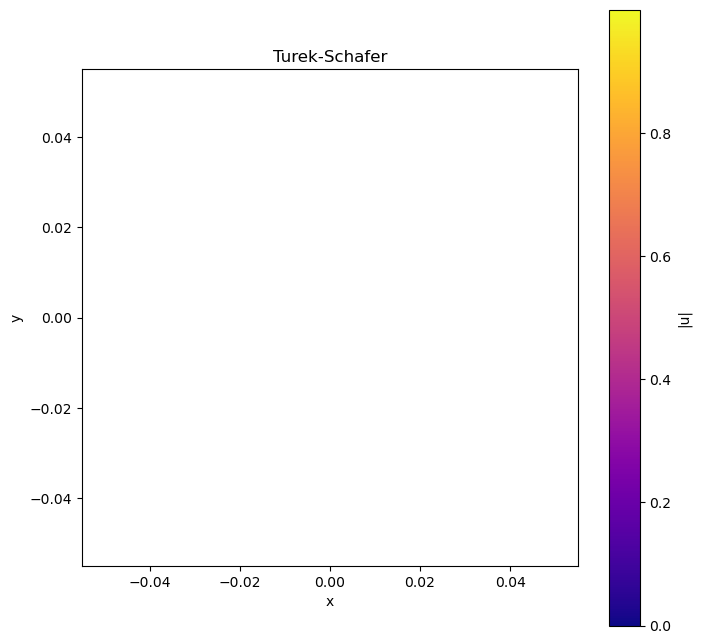

In [ ]:
u_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Turek-Schafer",background = False)